In [2]:
!pip3 install pandas numpy seaborn kaggle matplotlib scikit-learn

In [3]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import os
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold, cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Obtener los datos

In [4]:
from pathlib import Path
import shutil

# Cargar el archivo kaggle.json para autenticación con la API de Kaggle

# Suponiendo que kaggle.json está en el directorio actual
kaggle_json = Path('kaggle.json')
kaggle_dir = Path.home() / '.kaggle'
kaggle_dir.mkdir(exist_ok=True)
shutil.copy(str(kaggle_json), str(kaggle_dir / 'kaggle.json'))

# Establecer permisos adecuados
os.chmod(str(kaggle_dir / 'kaggle.json'), 0o600)

In [5]:
!kaggle datasets download -d neuromusic/avocado-prices -p ./ --unzip

Dataset URL: https://www.kaggle.com/datasets/neuromusic/avocado-prices
License(s): ODbL-1.0
  0%|                                                | 0.00/629k [00:00<?, ?B/s]
100%|█████████████████████████████████████████| 629k/629k [00:00<00:00, 602MB/s]


In [6]:
df = pd.read_csv("./avocado.csv")
df.head()

,Unnamed: 0,Date,AveragePrice,Total Volume,4046,4225,4770,Total Bags,Small Bags,Large Bags,XLarge Bags,type,year,region
0,0,2015-12-27,1.33,64236.62,1036.74,54454.85,48.16,8696.87,8603.62,93.25,0.0,conventional,2015,Albany
1,1,2015-12-20,1.35,54876.98,674.28,44638.81,58.33,9505.56,9408.07,97.49,0.0,conventional,2015,Albany
2,2,2015-12-13,0.93,118220.22,794.70,109149.67,130.50,8145.35,8042.21,103.14,0.0,conventional,2015,Albany
3,3,2015-12-06,1.08,78992.15,1132.00,71976.41,72.58,5811.16,5677.40,133.76,0.0,conventional,2015,Albany
4,4,2015-11-29,1.28,51039.60,941.48,43838.39,75.78,6183.95,5986.26,197.69,0.0,conventional,2015,Albany


# Estandarizacion y eliminacion de columnas

In [7]:

df.drop(columns=['Unnamed: 0'], inplace=True)

df.rename(columns={
    '4046': 'small_hass_sold',
    '4225': 'large_hass_sold',
    '4770': 'xlarge_hass_sold',
    'AveragePrice': 'averageprice',
    'Total Volume': 'total_volume',
    'Total Bags': 'total_bags',
    'Small Bags': 'small_bags',
    'Large Bags': 'large_bags',
    'XLarge Bags': 'xlarge_bags',
    'Date': 'date',
}, inplace=True)

# Tratamiento de valores nulos

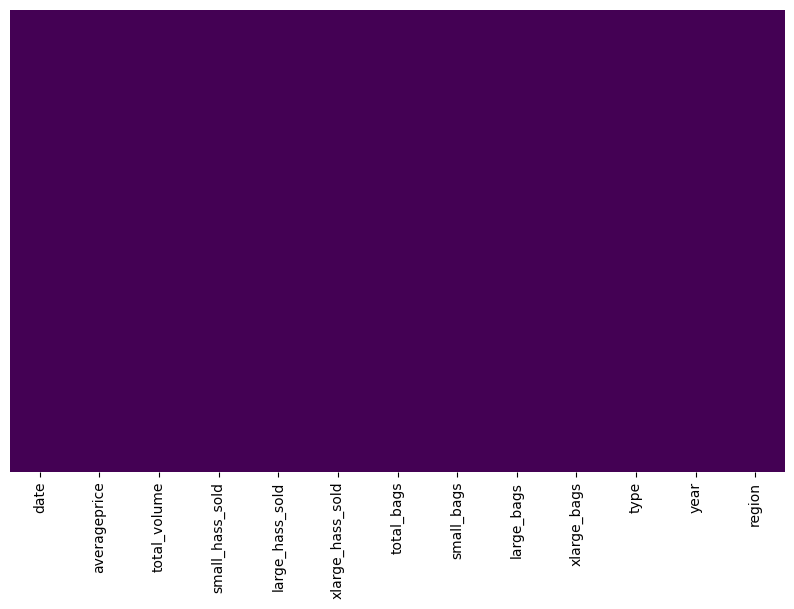

In [8]:
plt.figure(figsize=(10,6))
sns.heatmap(df.isnull(), cmap='viridis', cbar=False, yticklabels=False)
plt.show()

# Tratamiento de valores atipicos

In [9]:
numeric_cols = [
    'averageprice', 'total_volume', 'small_hass_sold', 'large_hass_sold',
    'xlarge_hass_sold', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags'
]


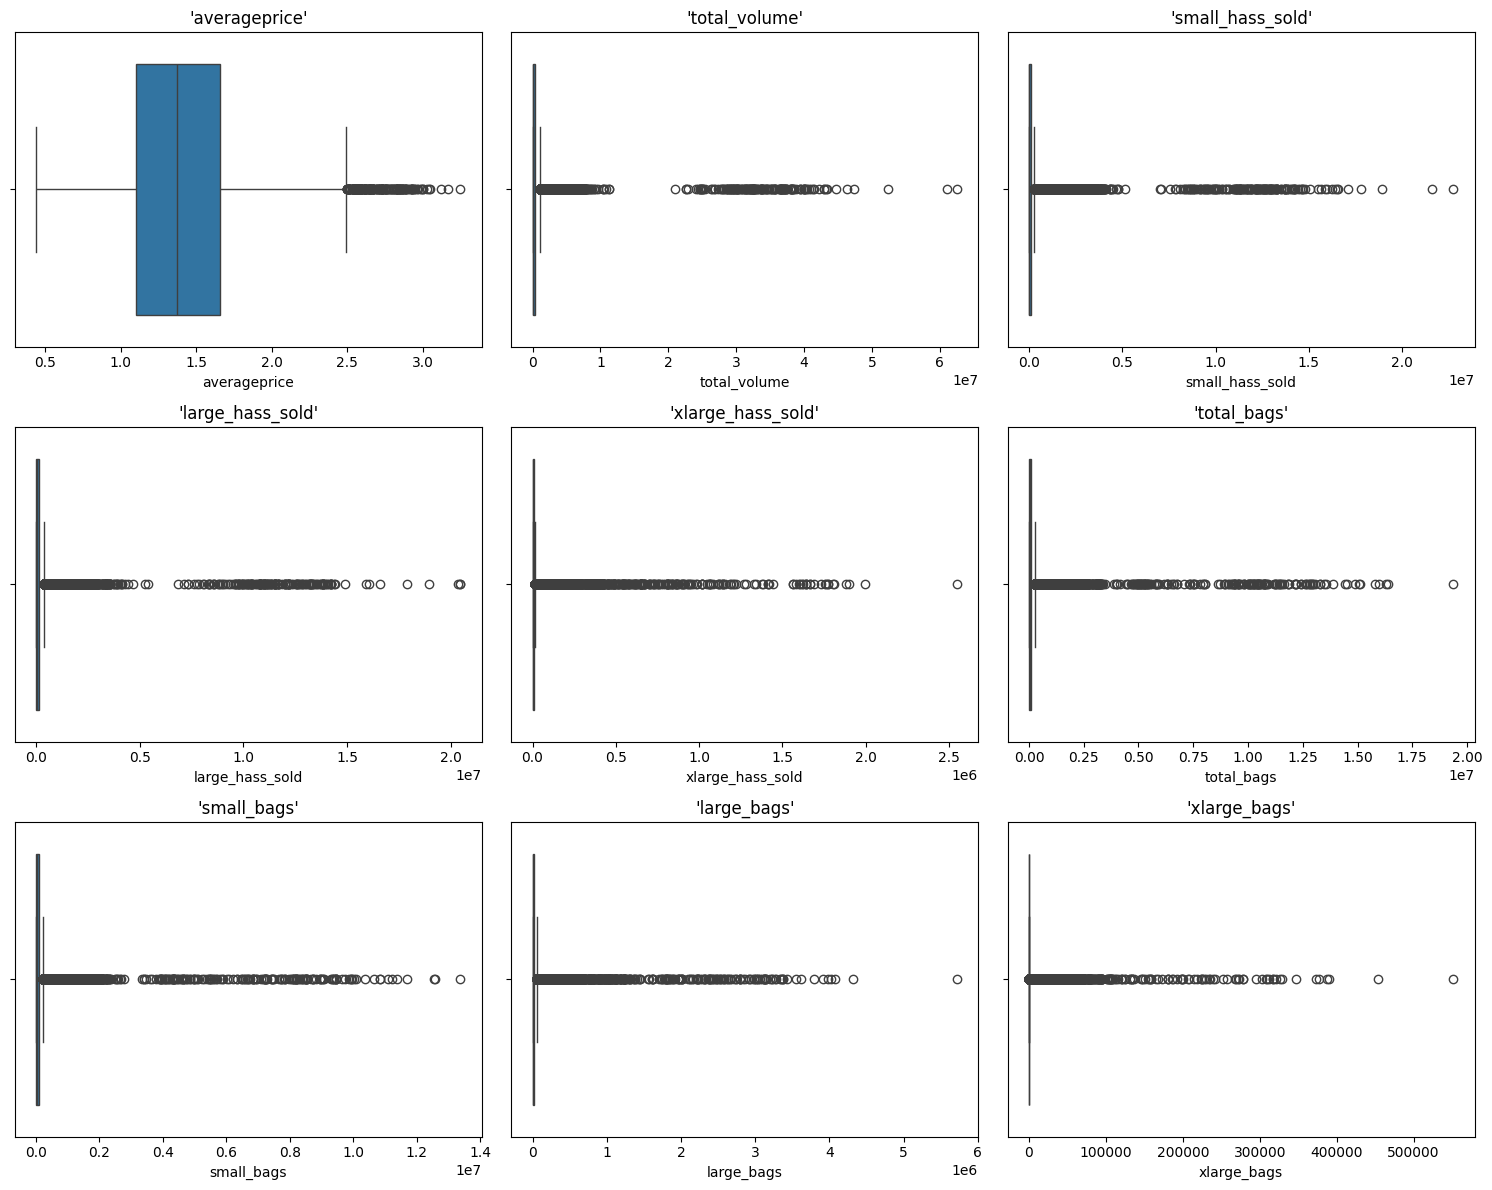

In [10]:
n = len(numeric_cols)
ncols = 3 
nrows = (n + ncols - 1) // ncols

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()

# Crear un boxplot por cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"'{col}'", fontsize=12)
    axes[i].set_xlabel(col)

# Eliminar ejes vacíos si sobran subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

## Detectar outliers

In [11]:
Q1 = df[numeric_cols].quantile(0.25)
Q3 = df[numeric_cols].quantile(0.75)
IQR = Q3 - Q1

outliers = ((df[numeric_cols] < (Q1 - 1.5 * IQR)) | (df[numeric_cols] > (Q3 + 1.5 * IQR)))
outlier_counts = outliers.sum().sort_values(ascending=False)

print(outlier_counts)

xlarge_bags         4014
xlarge_hass_sold    2918
large_bags          2707
total_bags          2533
large_hass_sold     2519
small_hass_sold     2518
small_bags          2407
total_volume        2297
averageprice         209
dtype: int64


## Analizar distribucion de los datos

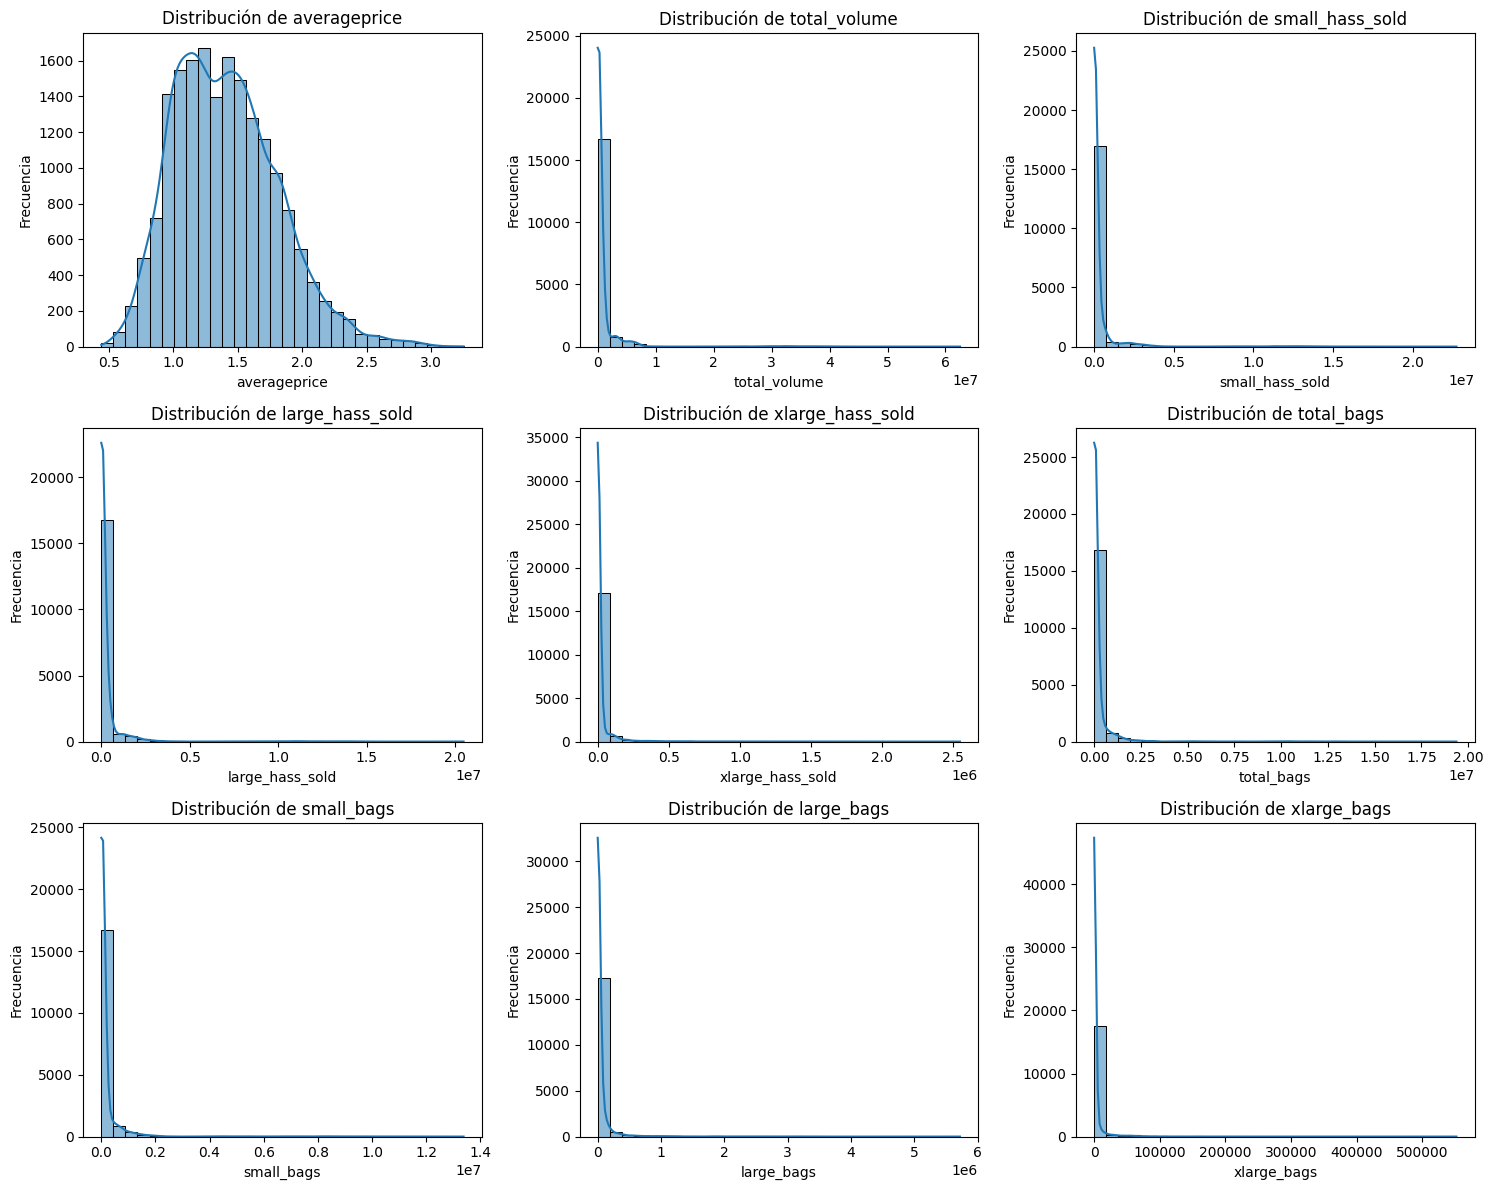

In [12]:
n = len(numeric_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols  # calcula filas necesarias

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()



## Reemplazo de outliers

In [13]:

for col in numeric_cols:
    Q1 = df[col].quantile(0.25)
    Q3 = df[col].quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - 1.5 * IQR
    upper = Q3 + 1.5 * IQR

    if col == 'averageprice':
        # reemplazar los datos atípicos por el promedio
        df.loc[df[col] < lower, col] = df[col].mean()
        df.loc[df[col] > upper, col] = df[col].mean()
    else:
        # Reemplazar atípicos por la mediana
        df.loc[df[col] < lower, col] = df[col].mean()
        df.loc[df[col] > upper, col] = df[col].mean()
df[numeric_cols].describe()





,averageprice,total_volume,small_hass_sold,large_hass_sold,xlarge_hass_sold,total_bags,small_bags,large_bags,xlarge_bags
count,18249.000000,1.824900e+04,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000,18249.000000
mean,1.391139,2.618605e+05,71834.860378,88243.981595,5077.691201,73823.146701,54590.436666,14243.641741,693.352325
std,0.377411,3.162123e+05,104105.458735,112727.412727,8366.464606,84746.479806,63776.045652,20062.667173,1282.080311
min,0.440000,8.456000e+01,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.100000,1.083858e+04,854.070000,3008.780000,0.000000,5088.640000,2849.420000,127.470000,0.000000
50%,1.370000,1.073768e+05,8645.300000,29061.020000,184.990000,39743.830000,26362.820000,2647.710000,0.000000
75%,1.650000,4.329623e+05,111020.200000,150206.860000,6243.420000,110783.370000,83337.670000,22029.250000,132.500000
max,2.490000,1.063584e+06,293008.424531,370026.960000,22839.735993,269169.000000,204056.330000,54855.780000,3106.426507


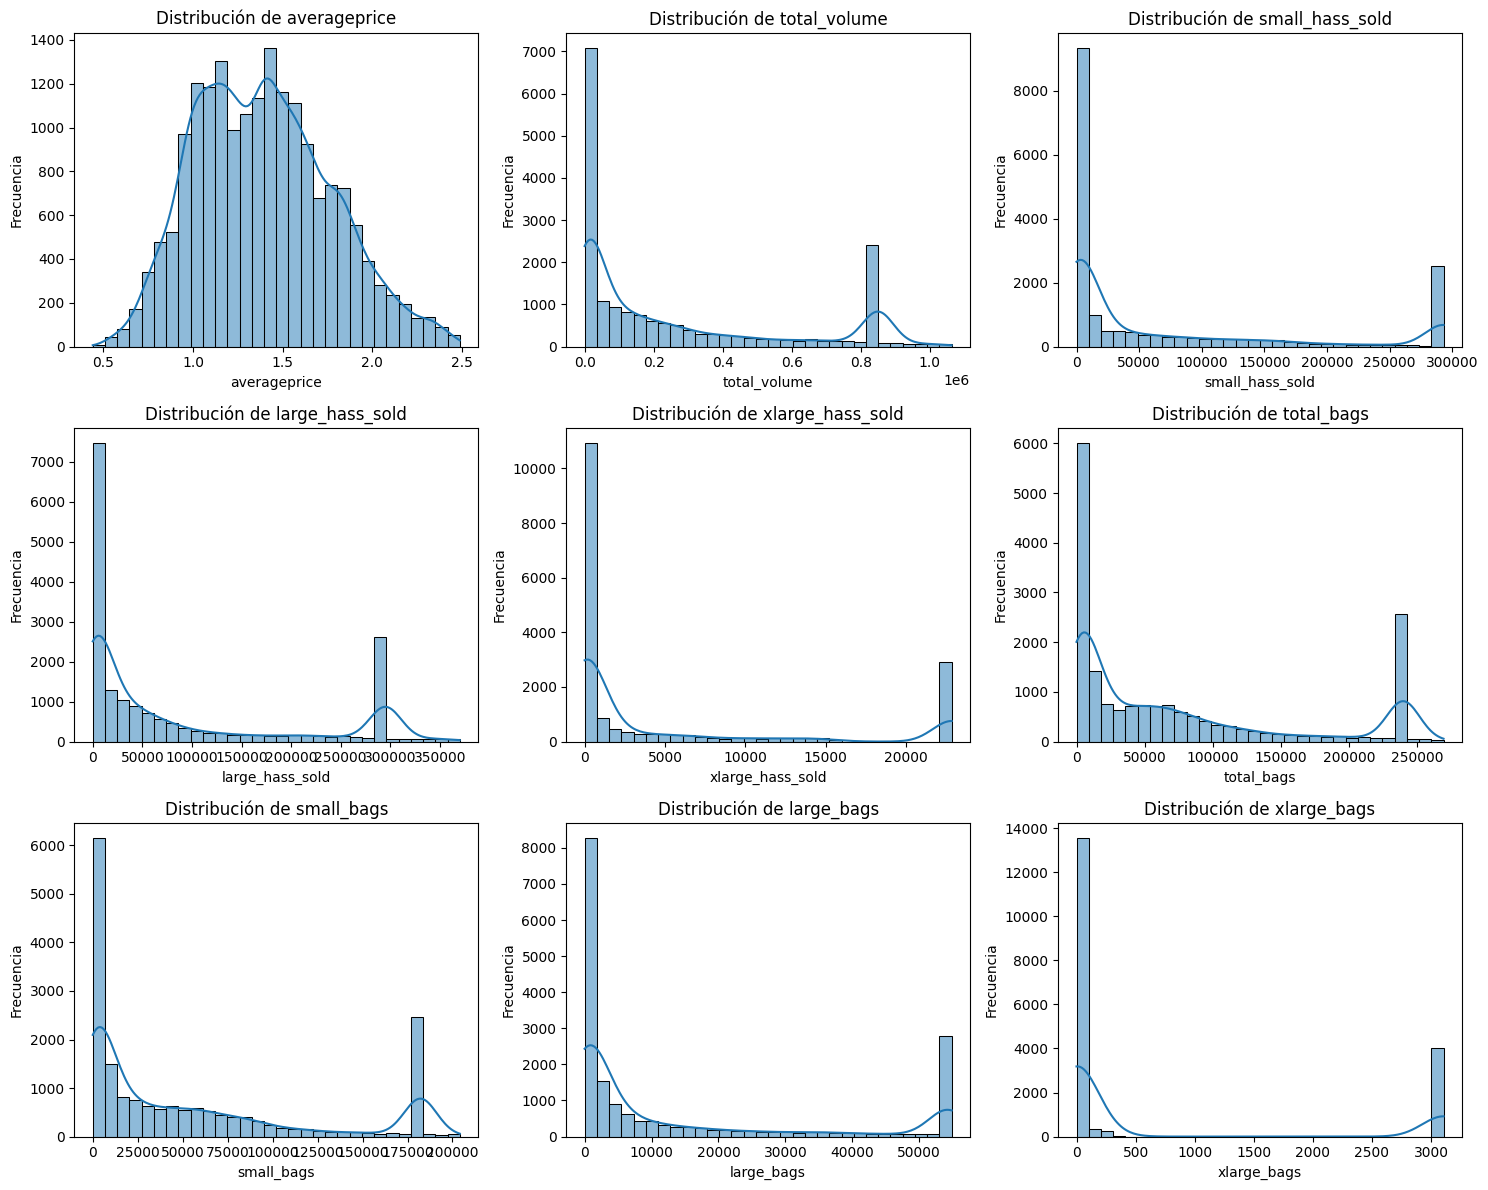

In [14]:
n = len(numeric_cols)
ncols = 3
nrows = (n + ncols - 1) // ncols  # calcula filas necesarias

plt.figure(figsize=(5 * ncols, 4 * nrows))

for i, col in enumerate(numeric_cols, 1):
    plt.subplot(nrows, ncols, i)
    sns.histplot(df[col], kde=True, bins=30)
    plt.title(f"Distribución de {col}")
    plt.xlabel(col)
    plt.ylabel("Frecuencia")

plt.tight_layout()
plt.show()


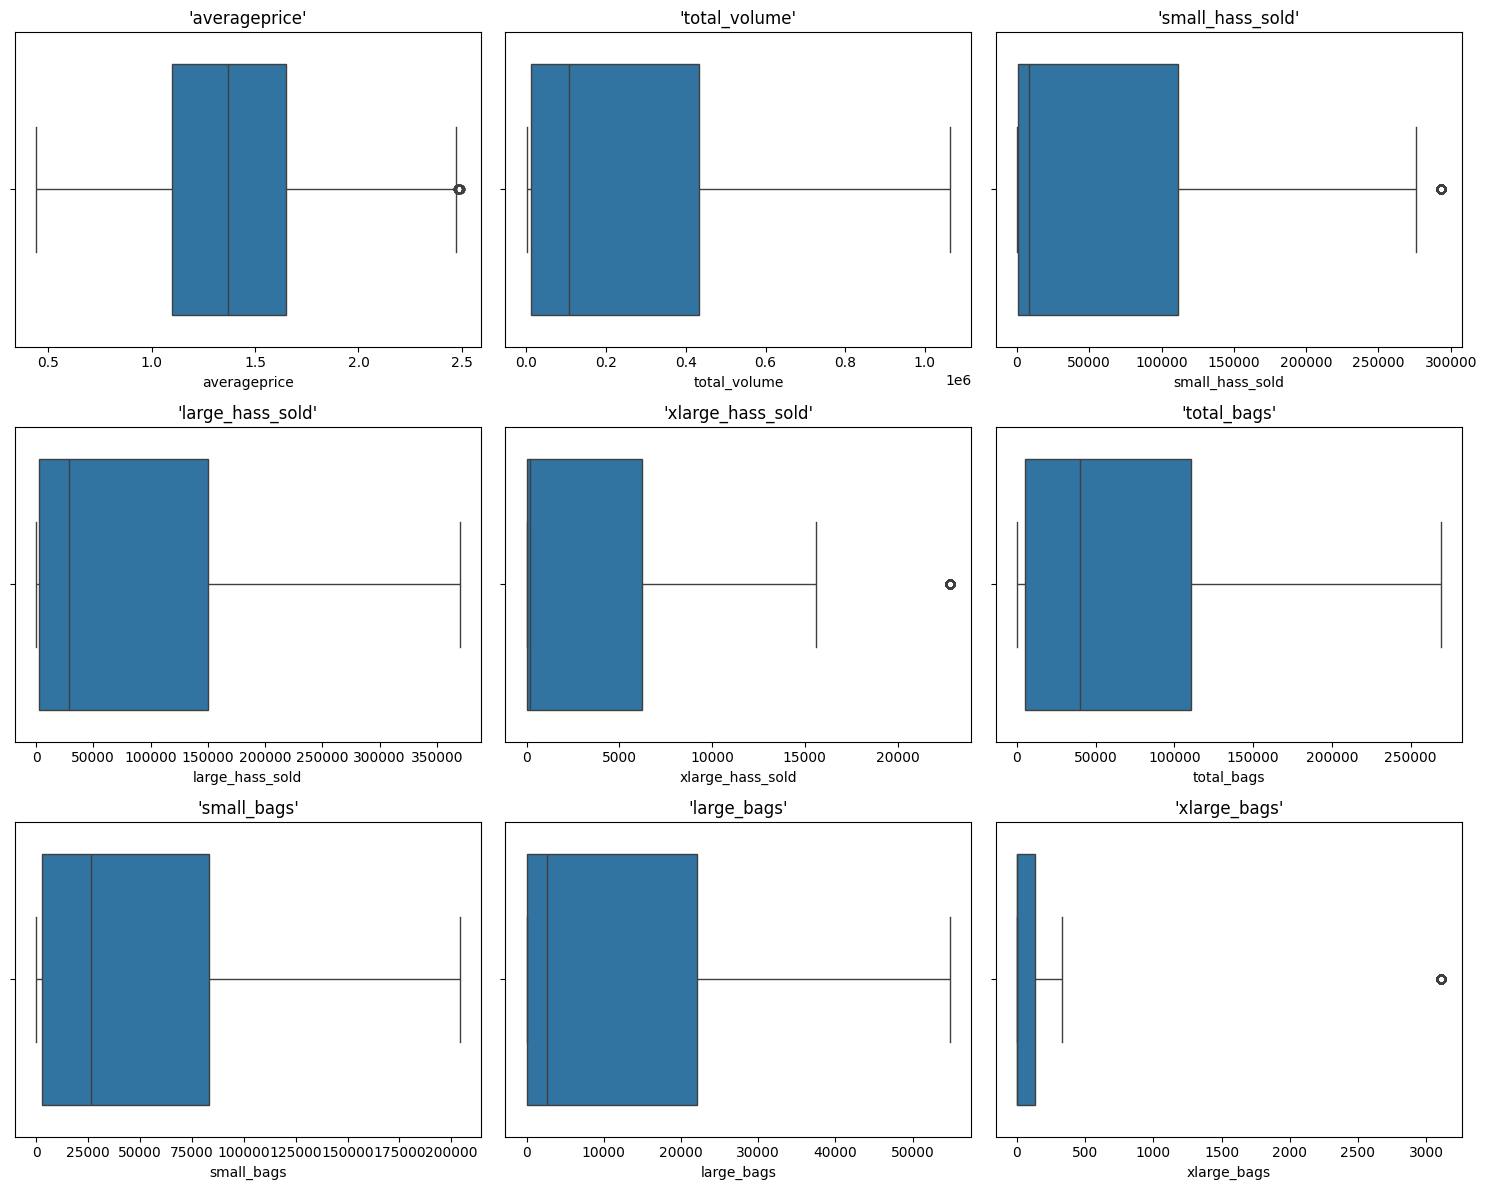

In [15]:
n = len(numeric_cols)
ncols = 3  # número de columnas de gráficos por fila (ajústalo según tu gusto)
nrows = (n + ncols - 1) // ncols  # calcula el número de filas necesarias

fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(5 * ncols, 4 * nrows))
axes = axes.flatten()  # convertir a lista para iterar fácilmente

# Crear un boxplot por cada columna numérica
for i, col in enumerate(numeric_cols):
    sns.boxplot(data=df, x=col, ax=axes[i])
    axes[i].set_title(f"'{col}'", fontsize=12)
    axes[i].set_xlabel(col)

# Eliminar ejes vacíos si sobran subplots
for j in range(i + 1, len(axes)):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

# Manejo de columnas categoricas y fechas

In [16]:
df = pd.get_dummies(df, columns=['type'], drop_first=True)
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
# Eliminar la columna 'date' si no es necesaria
df.drop(columns=['date'], inplace=True)

# Estandarizacion de los datos

In [17]:
cols_to_scale = [
   'total_volume', 'small_hass_sold', 'large_hass_sold',
    'xlarge_hass_sold', 'total_bags', 'small_bags', 'large_bags', 'xlarge_bags', 'year', 'month', 'day'
]

scaler = StandardScaler()
df_scaled = df.copy()
df_scaled[cols_to_scale] = scaler.fit_transform(df[cols_to_scale])

## Caso especial de la columna region

In [ ]:
df_train, df_test = train_test_split(df_scaled, test_size=0.3, random_state=42)
df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

TARGET_COLUMN = 'averageprice'
FEATURE_COLUMN = 'region'
N_FOLDS = 5

oof_encoded_features = []

kf = KFold(n_splits=N_FOLDS, shuffle=True, random_state=42)

for train_index, val_index in kf.split(df_train):
    X_train_fold, X_val_fold = df_train.loc[train_index], df_train.loc[val_index]

    target_mean_map = X_train_fold.groupby(FEATURE_COLUMN)[TARGET_COLUMN].mean()

    encoded_values = X_val_fold[FEATURE_COLUMN].map(target_mean_map)

    oof_encoded_features.append(encoded_values)

df_train[f'{FEATURE_COLUMN}_encoded'] = pd.concat(oof_encoded_features).sort_index()

global_target_mean_map = df_train.groupby(FEATURE_COLUMN)[TARGET_COLUMN].mean()

global_mean = df_train[TARGET_COLUMN].mean()

df_test[f'{FEATURE_COLUMN}_encoded'] = df_test[FEATURE_COLUMN].map(global_target_mean_map)

df_test[f'{FEATURE_COLUMN}_encoded'].fillna(global_mean, inplace=True)

df_train.drop(columns=[FEATURE_COLUMN], inplace=True)
df_test.drop(columns=[FEATURE_COLUMN], inplace=True)



/tmp/ipykernel_5396/1436760889.py:43: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df_test[f'{FEATURE_COLUMN}_encoded'].fillna(global_mean, inplace=True)


In [19]:
df_train.head()

,averageprice,total_volume,small_hass_sold,large_hass_sold,xlarge_hass_sold,total_bags,small_bags,large_bags,xlarge_bags,year,type_organic,month,day,region_encoded
0,0.95,1.862039,2.124573,1.812542,0.118170,1.956667,2.000873,1.998515,-0.481015,1.970504,False,-1.464959,-0.189449,1.052116
1,1.14,-0.562698,-0.453582,-0.638809,-0.329471,-0.390133,-0.216876,-0.709977,-0.538961,-0.157353,False,0.515780,-0.189449,1.360164
2,1.17,0.018804,0.165685,-0.074864,-0.388089,0.274525,0.564018,-0.572536,1.882207,0.906575,False,0.232818,0.038444,1.292935
3,0.99,1.862039,2.124573,1.835545,2.123063,1.956667,2.000873,1.998515,-0.497371,-1.221282,False,0.232818,-1.214968,1.406124
4,1.58,-0.784443,-0.628270,-0.744684,-0.606927,-0.834710,-0.812960,-0.692937,-0.540817,-1.221282,True,0.232818,-1.214968,1.245366


# Implementacion de los modelos

## Division de los datos

In [20]:
x_train = df_train.drop(columns=[TARGET_COLUMN])
y_train = df_train[TARGET_COLUMN]
x_test = df_test.drop(columns=[TARGET_COLUMN])
y_test = df_test[TARGET_COLUMN]

## Implementacion modelo random forest

In [21]:
rf = RandomForestRegressor(n_estimators=300, max_depth=20, random_state=40)

kf = KFold(n_splits=7, shuffle=True, random_state=40)
scoring_metric = 'neg_mean_squared_error'

cv_results = cross_val_score(
    estimator=rf,
    X=x_train,
    y=y_train,
    scoring=scoring_metric,
    cv=kf,
    n_jobs=4
)

mse_scores = -cv_results

print(f"MSE de cada Fold (7-Fold CV): {mse_scores}")
print(f"\nMedia del MSE (Cross-Validated): {np.mean(mse_scores):.4f}")
print(f"Desviación Estándar del MSE: {np.std(mse_scores):.4f}")

rf.fit(x_train, y_train)

MSE de cada Fold (7-Fold CV): [0.01933054 0.02013422 0.0186677  0.0199265  0.02106101 0.01959158
 0.01697433]

Media del MSE (Cross-Validated): 0.0194
Desviación Estándar del MSE: 0.0012


,n_estimators,300
,criterion,'squared_error'
,max_depth,20
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [22]:
y_pred_rf = rf.predict(x_test)
mse_rf = mean_squared_error(y_test, y_pred_rf)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)

print("Random Forest Regressor Metrics:")
print(f"Mean Squared Error: {mse_rf}")
print(f"Mean Absolute Error: {mae_rf}")
print(f"R^2 Score: {r2_rf}")



Random Forest Regressor Metrics:
Mean Squared Error: 0.017905118198411923
Mean Absolute Error: 0.09282075194637404
R^2 Score: 0.8732435046414482


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_5396/2238797840.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)


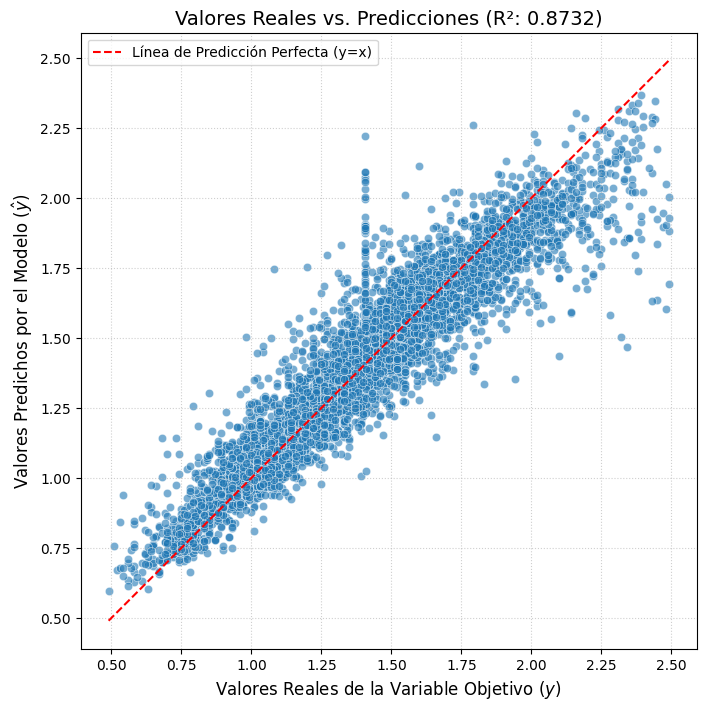

In [23]:
plot_df = pd.DataFrame({'Valores Reales (y_test)': y_test,
                        'Predicciones (y_pred_rf)': y_pred_rf})

r2 = r2_score(y_test, y_pred_rf)

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Valores Reales (y_test)', y='Predicciones (y_pred_rf)', data=plot_df, alpha=0.6)

min_val = min(y_test.min(), y_pred_rf.min())
max_val = max(y_test.max(), y_pred_rf.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Línea de Predicción Perfecta (y=x)')

plt.title(f'Valores Reales vs. Predicciones (R²: {r2:.4f})', fontsize=14)
plt.xlabel('Valores Reales de la Variable Objetivo ($y$)', fontsize=12)
plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Implementacion modelo GradientBoosting

In [24]:
gb = GradientBoostingRegressor(n_estimators=500, learning_rate=0.02, max_depth=10, random_state=42)

kf = KFold(n_splits=7, shuffle=True, random_state=42)
scoring_metric = 'neg_mean_squared_error'

cv_results = cross_val_score(
    estimator=gb,
    X=x_train,
    y=y_train,
    scoring=scoring_metric,
    cv=kf,
    n_jobs=4
)

mse_scores = -cv_results

print(f"MSE de cada Fold (7-Fold CV): {mse_scores}")
print(f"\nMedia del MSE (Cross-Validated): {np.mean(mse_scores):.4f}")
print(f"Desviación Estándar del MSE: {np.std(mse_scores):.4f}")

gb.fit(x_train, y_train)

MSE de cada Fold (7-Fold CV): [0.01612785 0.01892299 0.01781883 0.02124221 0.01726038 0.0189821
 0.01823688]

Media del MSE (Cross-Validated): 0.0184
Desviación Estándar del MSE: 0.0015


,loss,'squared_error'
,learning_rate,0.02
,n_estimators,500
,subsample,1.0
,criterion,'friedman_mse'
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_depth,10
,min_impurity_decrease,0.0
,init,None


In [25]:
y_pred_gb = gb.predict(x_test)
mse_gb = mean_squared_error(y_test, y_pred_gb)
mae_gb = mean_absolute_error(y_test, y_pred_gb)
r2_gb = r2_score(y_test, y_pred_gb)

print("Gradient Boosting Regressor Metrics:")
print(f"Mean Squared Error: {mse_gb}")
print(f"Mean Absolute Error: {mae_gb}")
print(f"R^2 Score: {r2_gb}")


Gradient Boosting Regressor Metrics:
Mean Squared Error: 0.01624810421940517
Mean Absolute Error: 0.08749390973372784
R^2 Score: 0.8849740770069326


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_5396/3856898757.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)


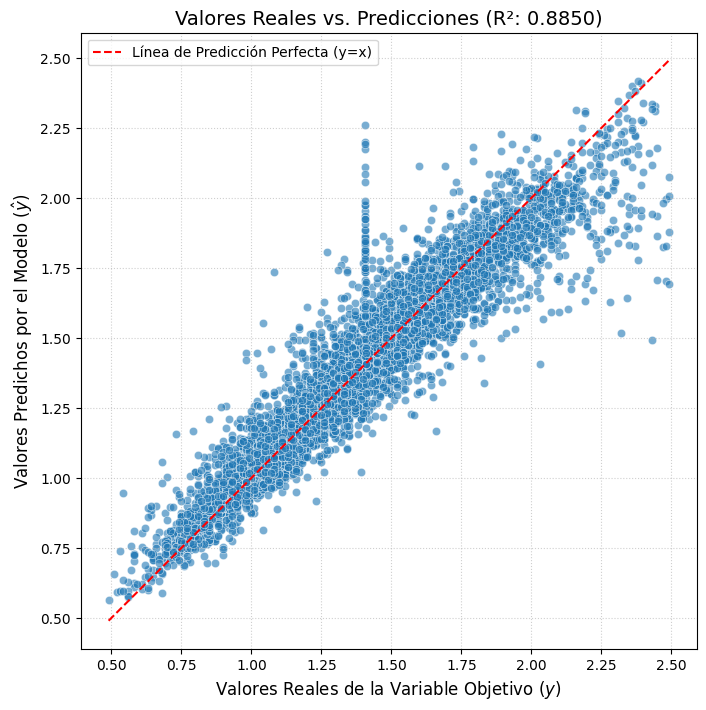

In [26]:
plot_df = pd.DataFrame({'Valores Reales (y_test)': y_test,
                        'Predicciones (y_pred_gb)': y_pred_gb})

r2 = r2_score(y_test, y_pred_gb)

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Valores Reales (y_test)', y='Predicciones (y_pred_gb)', data=plot_df, alpha=0.6)

min_val = min(y_test.min(), y_pred_gb.min())
max_val = max(y_test.max(), y_pred_gb.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Línea de Predicción Perfecta (y=x)')

plt.title(f'Valores Reales vs. Predicciones (R²: {r2:.4f})', fontsize=14)
plt.xlabel('Valores Reales de la Variable Objetivo ($y$)', fontsize=12)
plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Implementacion modelo MLP

In [27]:
mlp = MLPRegressor(hidden_layer_sizes=(200, 175, 150, 100, 75, 50, 25, 50), activation='relu', solver='adam', max_iter=500, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
scoring_metric = 'neg_mean_squared_error'

cv_results = cross_val_score(
    estimator=mlp,
    X=x_train,
    y=y_train,
    scoring=scoring_metric,
    cv=kf,
    n_jobs=4
)

mse_scores = -cv_results

print(f"MSE de cada Fold (5-Fold CV): {mse_scores}")
print(f"\nMedia del MSE (Cross-Validated): {np.mean(mse_scores):.4f}")
print(f"Desviación Estándar del MSE: {np.std(mse_scores):.4f}")

mlp.fit(x_train, y_train)

MSE de cada Fold (5-Fold CV): [0.02948009 0.02790135 0.02963365 0.02953991 0.03200042]

Media del MSE (Cross-Validated): 0.0297
Desviación Estándar del MSE: 0.0013


,loss,'squared_error'
,hidden_layer_sizes,"(200, ...)"
,activation,'relu'
,solver,'adam'
,alpha,0.0001
,batch_size,'auto'
,learning_rate,'constant'
,learning_rate_init,0.001
,power_t,0.5
,max_iter,500
,shuffle,True


In [28]:
y_pred_mlp = mlp.predict(x_test)
mse_mlp = mean_squared_error(y_test, y_pred_mlp)
mae_mlp = mean_absolute_error(y_test, y_pred_mlp)
r2_mlp = r2_score(y_test, y_pred_mlp)

print("MLP Regressor Metrics:")
print(f"Mean Squared Error: {mse_mlp}")
print(f"Mean Absolute Error: {mae_mlp}")
print(f"R^2 Score: {r2_mlp}")

MLP Regressor Metrics:
Mean Squared Error: 0.024301607635117742
Mean Absolute Error: 0.11168902444066124
R^2 Score: 0.8279605540007346


<>:18: SyntaxWarning: invalid escape sequence '\h'
<>:18: SyntaxWarning: invalid escape sequence '\h'
/tmp/ipykernel_5396/859153216.py:18: SyntaxWarning: invalid escape sequence '\h'
  plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)


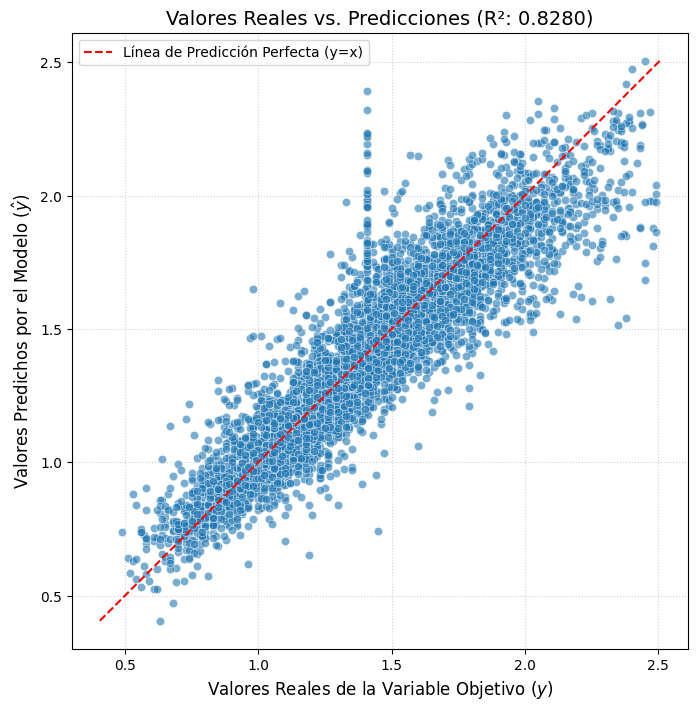

In [29]:
plot_df = pd.DataFrame({'Valores Reales (y_test)': y_test,
                        'Predicciones (y_pred_mlp)': y_pred_mlp})

r2 = r2_score(y_test, y_pred_mlp)

plt.figure(figsize=(8, 8))

sns.scatterplot(x='Valores Reales (y_test)', y='Predicciones (y_pred_mlp)', data=plot_df, alpha=0.6)

min_val = min(y_test.min(), y_pred_mlp.min())
max_val = max(y_test.max(), y_pred_mlp.max())
line_coords = np.linspace(min_val, max_val, 100)

plt.plot(line_coords, line_coords, color='red', linestyle='--', label='Línea de Predicción Perfecta (y=x)')

plt.title(f'Valores Reales vs. Predicciones (R²: {r2:.4f})', fontsize=14)
plt.xlabel('Valores Reales de la Variable Objetivo ($y$)', fontsize=12)
plt.ylabel('Valores Predichos por el Modelo ($\hat{y}$)', fontsize=12)
plt.legend()
plt.grid(True, linestyle=':', alpha=0.6)
plt.gca().set_aspect('equal', adjustable='box')
plt.show()

## Compracion de modelos

Tabla de Métricas para Visualización:
          Random Forest (RF)  Gradient Boosting (GB)  MLP (Red Neuronal)
MSE                 0.017905                0.016248            0.024302
MAE                 0.092821                0.087494            0.111689
R² Score            0.873244                0.884974            0.827961


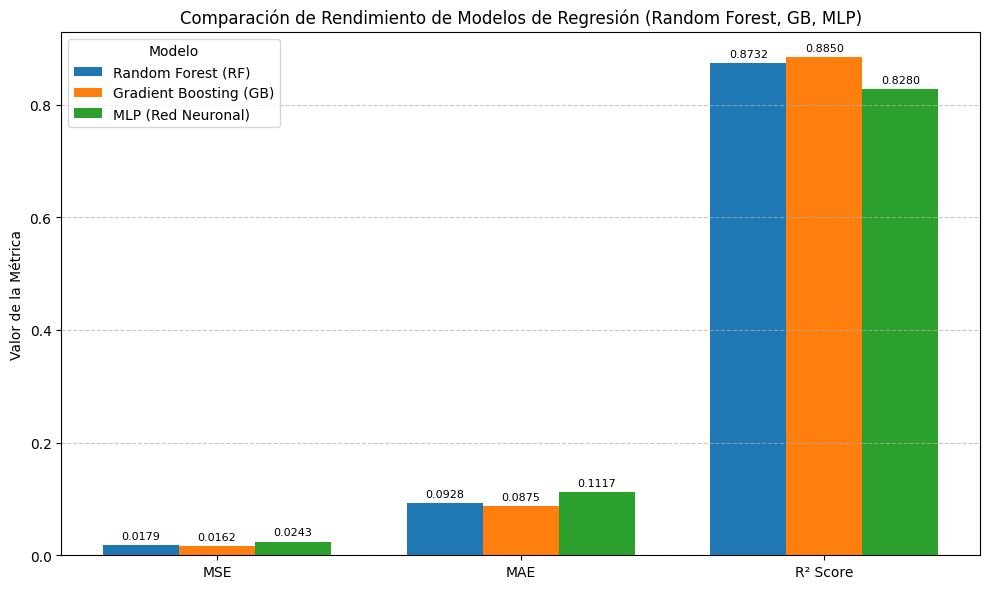

In [30]:
data = {
    'Random Forest (RF)': [mse_rf, mae_rf, r2_rf],
    'Gradient Boosting (GB)': [mse_gb, mae_gb, r2_gb],
    'MLP (Red Neuronal)': [mse_mlp, mae_mlp, r2_mlp]
}

# 2. Crear el DataFrame, usando los nombres de las métricas como índice
df_metrics = pd.DataFrame(data, index=['MSE', 'MAE', 'R² Score'])

print("Tabla de Métricas para Visualización:")
print(df_metrics)

metric_names = df_metrics.index
model_names = df_metrics.columns
num_metrics = len(metric_names)
num_models = len(model_names)

# Configuración de Matplotlib
fig, ax = plt.subplots(figsize=(10, 6))
width = 0.25  # Ancho de las barras

# Crear las posiciones de los grupos de barras
x = np.arange(num_metrics)

# Bucle para dibujar las barras de cada modelo
for i, model in enumerate(model_names):
    # Calcular la posición de la barra para este modelo dentro de cada métrica
    offset = (i - (num_models - 1) / 2) * width
    
    # Dibujar las barras
    rects = ax.bar(x + offset, df_metrics.loc[:, model], width, label=model)
    
    # Añadir las etiquetas de valor en la parte superior de cada barra
    for rect in rects:
        height = rect.get_height()
        ax.annotate(f'{height:.4f}',
                    xy=(rect.get_x() + rect.get_width() / 2, height),
                    xytext=(0, 3),  # 3 puntos de desplazamiento vertical
                    textcoords="offset points",
                    ha='center', va='bottom', fontsize=8)

# Configuración de Ejes y Títulos
ax.set_ylabel('Valor de la Métrica')
ax.set_title('Comparación de Rendimiento de Modelos de Regresión (Random Forest, GB, MLP)')
ax.set_xticks(x)
ax.set_xticklabels(metric_names)
ax.legend(title='Modelo')
ax.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar el gráfico
plt.tight_layout()
plt.show()